In [29]:
from untrade.client import Client

from pykalman import KalmanFilter
from hurst import compute_Hc

import pandas as pd
import warnings 
warnings.filterwarnings("ignore")
import numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import timedelta, datetime
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from colorama import Fore, Back, Style

import json


In [30]:
def process_data(data):
    """
    Processes and calculates various indicators for BTC and ETH data.

    Parameters:
    - data: Input DataFrame (not directly used but kept for API compatibility).

    Returns:
    - DataFrame with calculated indicators.
    """

    # Load BTC and ETH data
    btc_data = pd.read_csv("btc_data/BTC_2019_2023_1h.csv", parse_dates=['datetime'])
    eth_data = pd.read_csv("eth_data/ETHUSDT_1h.csv", parse_dates=['datetime'])

    # Preprocess columns
    btc_data = btc_data[['datetime', 'open', 'high', 'low', 'close', 'volume']].rename(
        columns={'open': 'btc_open', 'high': 'btc_high', 'low': 'btc_low', 'close': 'btc_close', 'volume': 'btc_volume'}
    )
    eth_data = eth_data[['datetime', 'open', 'high', 'low', 'close', 'volume']].rename(
        columns={'open': 'eth_open', 'high': 'eth_high', 'low': 'eth_low', 'close': 'eth_close', 'volume': 'eth_volume'}
    )

    # Merge data and filter date range
    data = pd.merge(btc_data, eth_data, on='datetime', how='inner')

    class Indicators:
        data = None     # Shared DataFrame for all methods

        @classmethod
        def initialize(cls, data):
            """
            Initialize the class with a DataFrame.
            """
            cls.data = data

        # Function: Calculate RSI
        @classmethod
        def calculate_rsi(cls, asset, window=14):
            """
            Calculate RSI for the given asset and add it to the DataFrame.
            """
            column = f'{asset}_close'
            delta = cls.data[column].diff()
            gain = np.where(delta > 0, delta, 0)
            loss = np.where(delta < 0, -delta, 0)
            avg_gain = pd.Series(gain).rolling(window=window).mean()
            avg_loss = pd.Series(loss).rolling(window=window).mean()
            rs = avg_gain / avg_loss
            cls.data[f'{asset}_rsi'] = 100 - (100 / (1 + rs))

        # Function: Calculate ATR
        @classmethod
        def calculate_atr(cls, asset, window=12): #CHANGED TO 12 HOURS
            """
            Calculate ATR for the given asset and add it to the DataFrame.
            """
            high_col = f'{asset}_high'
            low_col = f'{asset}_low'
            close_col = f'{asset}_close'
            high_low = cls.data[high_col] - cls.data[low_col]
            high_close = np.abs(cls.data[high_col] - cls.data[close_col].shift())
            low_close = np.abs(cls.data[low_col] - cls.data[close_col].shift())
            true_range = pd.DataFrame({'high_low': high_low, 'high_close': high_close, 'low_close': low_close}).max(axis=1)
            cls.data[f'{asset}_atr'] = true_range.rolling(window=window).mean()
        
        # Function: Apply Kalman Filter
        @classmethod
        def apply_kalman_filter(cls, asset, transition_covariance=0.01):
            """
            Apply Kalman filter to the close prices of the given asset and add the filtered prices to the DataFrame.
            """
            column = f'{asset}_close'
            prices = cls.data[column].values.reshape(-1, 1)
            kf = KalmanFilter(
                transition_matrices=[1],
                observation_matrices=[1],
                initial_state_mean=prices[0],
                initial_state_covariance=1,
                observation_covariance=0.1,
                transition_covariance=transition_covariance
            )
            state_means, _ = kf.filter(prices)
            cls.data[f'{asset}_close_filtered'] = state_means.flatten()

        # Function: Calculate Correlation
        @classmethod
        def calculate_correlation(cls, asset1, asset2):
            """
            Calculate the correlation between the two assets and add it to the DataFrame.
            """
            column1 = f'{asset1}_close'
            column2 = f'{asset2}_close'
            cls.data[f'{asset1}_{asset2}_correlation'] = cls.data[column1].rolling(7).corr(cls.data[column2])
        
        # Functions: Hurst Exponent
        @classmethod
        def hurst_exponent(cls, ts):
            """
            Calculate the Hurst exponent using rescaled range analysis.
            """
            H, _, _ = compute_Hc(ts)
            return H
        
        @classmethod
        def rolling_hurst_exponent(cls, asset, window):
            """
            Apply the Hurst exponent calculation in a rolling window for the given asset.
            """
            column = f'{asset}_close'
            cls.data[f'{asset}_hurst'] = cls.data[column].rolling(window).apply(cls.hurst_exponent, raw=True)
        
        # Function: Calculate Bollinger Bands
        @classmethod
        def calculate_bollinger_bands(cls, asset, window=20, num_std=2):
            """
            Calculate Bollinger Bands for the given asset and add them to the DataFrame.
            """
            column = f'{asset}_close'
            middle = cls.data[column].rolling(window=window).mean()
            std = cls.data[column].rolling(window=window).std()
            cls.data[f'{asset}_bollinger_middle'] = middle
            cls.data[f'{asset}_bollinger_upper'] = middle + (std * num_std)
            cls.data[f'{asset}_bollinger_lower'] = middle - (std * num_std)

        # Function: Calculate Supertrend
        @classmethod
        def calculate_supertrend(cls, asset, period=12, multiplier=2.5):
            """
            Calculate Supertrend for the given asset and add it to the DataFrame.
            """
            high_col, low_col, close_col = f'{asset}_high', f'{asset}_low', f'{asset}_close'
            atr = cls.data[f'{asset}_atr']
            middle_band = (data[high_col] + data[low_col]) / 2
            upper_band = middle_band + (multiplier * atr)
            lower_band = middle_band - (multiplier * atr)

            supertrend = np.zeros(len(cls.data))
            supertrend_direction = np.zeros(len(cls.data))

            # First value initialization
            supertrend[0] = upper_band.iloc[0]
            trend = 1
            
            for i in range(1, len(cls.data)):
                if cls.data[close_col].iloc[i] > supertrend[i-1]:
                    trend = 1
                elif cls.data[close_col].iloc[i] < supertrend[i-1]:
                    trend = -1
                
                if trend == 1:
                    if lower_band[i] < supertrend[i-1]:
                        supertrend[i] = supertrend[i-1]
                    else:
                        supertrend[i] = lower_band[i]
                        
                elif trend == -1:
                    if upper_band[i] > supertrend[i-1]:
                        supertrend[i] = supertrend[i-1]
                    else:
                        supertrend[i] = upper_band[i]
                
                supertrend_direction[i] = trend

            # Add results to the DataFrame
            cls.data[f'{asset}_supertrend'] = supertrend
            cls.data[f'{asset}_supertrend_direction'] = supertrend_direction
            
        # Function: Calculate CUSUM 
        @classmethod
        def calculate_cusum(cls, asset, k):
            """
            Calculate CUSUM for the given asset and update cls.data with S_hi and S_lo.

            Parameters:
            - asset: The asset prefix (e.g., 'btc' or 'eth').
            - mu_col: The column representing the expected mean (e.g., filtered price).
            - k_col: The column representing the threshold values.
            """
            n = len(cls.data)
            S_hi = np.zeros(n)
            S_lo = np.zeros(n)
            price = cls.data[f'{asset}_close'].values
            mu = cls.data[f'{asset}_close_filtered'].values
            
            for i in range(1, n):
                S_hi[i] = max(0, S_hi[i-1] + (price[i] - mu[i] - k[i]))
                S_lo[i] = max(0, S_lo[i-1] + (-price[i] + mu[i] - k[i]))
            
            return S_hi, S_lo

        # Function: Identify Regimes
        @classmethod
        def identify_regimes(cls, asset, window=5, delta=0.8, h_factor=1.5):
            """
            Identify regimes for the given asset based on CUSUM and update cls.data with regime information.

            Parameters:
            - asset: The asset prefix (e.g., 'btc' or 'eth').
            - window: Rolling window size for calculating standard deviation.
            - delta: Scaling factor for threshold values.
            - h_factor: Scaling factor for regime threshold.
            """
            price_col = f'{asset}_close'
            filtered_col = f'{asset}_close_filtered'

            # Calculate rolling standard deviation and thresholds
            rolling_sigma = cls.data[price_col].rolling(window=window).std()
            k = delta * rolling_sigma

            # Calculate CUSUM
            S_hi, S_lo = cls.calculate_cusum(asset, k.values)
            
            # Define regime thresholds
            rolling_h = h_factor * rolling_sigma
            
            # Identify bullish regimes
            regime = pd.Series('bearish', index=cls.data.index)
            regime[S_hi > rolling_h] = 'bullish'
            
            # Add regime results to cls.data
            cls.data[f'{asset}_regime'] = regime

    # Calculate Indicators
    Indicators.initialize(data)
    Indicators.calculate_rsi('btc')
    Indicators.calculate_rsi('eth')
    Indicators.calculate_atr('btc')
    Indicators.calculate_atr('eth')
    Indicators.apply_kalman_filter('btc')
    Indicators.apply_kalman_filter('eth')
    Indicators.calculate_correlation('btc','eth')

    Indicators.rolling_hurst_exponent('btc', 5 * 24)
    Indicators.rolling_hurst_exponent('eth', 5 * 24)
    Indicators.calculate_bollinger_bands('btc')
    Indicators.calculate_bollinger_bands('eth')

    Indicators.calculate_supertrend('btc')
    Indicators.calculate_supertrend('eth')
    Indicators.identify_regimes('btc')
    Indicators.identify_regimes('eth')
    
    data = Indicators.data[(data['datetime'] >= '2020-01-01') & (data['datetime'] <= '2023-12-31')].reset_index(drop=True)

    return data


STRATEGY

In [31]:
def strat(data, maxhold=28, cooldown=24):
    """
    Strategy function to analyze and generate trading signals.

    Parameters:
    - data: DataFrame containing market data.

    Returns:
    - final_data: DataFrame with generated signals and trade types.
    """

    # Initialize signals and trade_type column
    data['signals'] = 0
    data['trade_type'] = " "

    # Helper function to close positions
    def close_position(stoploss=False):
        """
        Closes the current position and updates the necessary variables.

        Parameters:
        - stoploss: Boolean indicating if the closure is due to a stop-loss hit. If True, enables trading cooldown.
        """
        nonlocal current_position, entry_price, entry_date, highest_since_entry, lowest_since_entry, last_trailing_stop_time

        if current_position == 1:
            data.at[i, 'signals'] = -1
        elif current_position == -1:
            data.at[i, 'signals'] = 1
        data.at[i, 'trade_type'] = 'close'
        current_position = 0
        entry_price = None  # Reset entry price
        entry_date = None  # Reset entry date
        highest_since_entry = None  # Reset highest price since entry
        lowest_since_entry = None  # Reset lowest price since entry

        if stoploss:
            last_trailing_stop_time = current_time

        return
    
    # Initialize Trading Variables
    entry_price = None
    entry_date = None
    current_position = 0    # 0 = no position, 1 = long position, -1 = short position
    highest_since_entry = None
    lowest_since_entry = None
    last_trailing_stop_time = None

    # Strategy Thresholds and Parameters
    CORRELATION_THRESHOLD = 0.6 
    HURST_THRESHOLD = 0.5
    RSI_THRESHOLD_HIGH = 70
    RSI_THRESHOLD_LOW = 30
    BTC_ATR_THRESHOLD_STOP = 0.025  # Above which position will be exited
    BTC_ATR_THRESHOLD_TRADE = 0.01  # Below which trading can take place

    TRAILING_STOPLOSS_PCT = 0.10    # Trailing stoploss percentage
    MAX_HOLDING_PERIOD = maxhold * 24 * 2    # 2 weeks in hours
    COOLDOWN_PERIOD = cooldown * 2         # Cooldown period for any stop-loss hit


    # Main loop to process data hour by hour
    for i in range(len(data)):
        current_price = data['eth_close'].iloc[i]
        current_time = data['datetime'].iloc[i]
        high_price = data['eth_high'].iloc[i]
        low_price = data['eth_low'].iloc[i]

        # Halt trading during cooldown period
        if last_trailing_stop_time is not None:
            time_since_trailing_stop = (current_time - last_trailing_stop_time).total_seconds() / 3600
            if time_since_trailing_stop < COOLDOWN_PERIOD:
                continue
        
        # Ensure open positions are closed at the end of the data
        if i == len(data) - 1 and current_position != 0:
            close_position()
            continue
        
        # Handle trailing stop-loss for long positions
        if current_position == 1:
            highest_since_entry = max(highest_since_entry or current_price, current_price)
            trailing_stop_price = highest_since_entry * (1 - TRAILING_STOPLOSS_PCT)
            lowest_24hr = data.loc[max(0, i-24):i, 'eth_low'].min()
            stop_price = (lowest_24hr + trailing_stop_price) / 2 if lowest_24hr < trailing_stop_price else lowest_24hr
                
            if current_price <= stop_price:
                close_position(stoploss=True)
                continue
                
        # Handle trailing stop-loss for short positions  
        elif current_position == -1:
            lowest_since_entry = min(lowest_since_entry or low_price, low_price)
            trailing_stop_price = lowest_since_entry * (1 + TRAILING_STOPLOSS_PCT)

            if current_price >= trailing_stop_price:
                close_position(stoploss=True)
                continue
        
        # Check max holding period and volatility-based stop-loss
        if current_position != 0 and entry_price is not None:
            time_since_entry = (current_time - entry_date).total_seconds() / 3600
            if time_since_entry >= MAX_HOLDING_PERIOD: # Exceeded max holding period
                close_position(stoploss=True)
                continue
            if data['btc_atr'][i] > BTC_ATR_THRESHOLD_STOP * data['btc_open'][i]: # BTC indicating high-volatility(>0.025)
                close_position(stoploss=True)
                continue

        # Contained ATR(<0.01), trend-following Hurst, and highly correlated(BTC-ETH) trading region conditions
        if (data['btc_atr'][i] < BTC_ATR_THRESHOLD_TRADE * data['btc_open'][i] and 
            data['btc_eth_correlation'][i] > CORRELATION_THRESHOLD and 
            data['eth_hurst'].iloc[i] > HURST_THRESHOLD):  

            if current_position == 0:
                # LONG ENTRY CONDITIONS
                if (
                    data['btc_rsi'][i] > RSI_THRESHOLD_HIGH and     # 70 
                    data['btc_regime'][i] == 'bullish' and
                    data['btc_close'][i] > data['btc_bollinger_middle'][i] and
                    data['eth_supertrend_direction'][i] == 1):

                    data.at[i, 'signals'] = 1
                    data.at[i, 'trade_type'] = 'long'
                    current_position = 1
                    entry_price = current_price
                    entry_date = data['datetime'].iloc[i]
                    highest_since_entry = current_price
                    
                # SHORT ENTRY CONDITIONS
                if (
                    data['btc_rsi'][i] < RSI_THRESHOLD_LOW and     # 30
                    data['btc_regime'][i] == 'bearish' and
                    data['btc_close'][i] < data['btc_bollinger_lower'][i] and
                    data['eth_supertrend_direction'][i] == -1):  

                    data.at[i, 'signals'] = -1
                    data.at[i, 'trade_type'] = 'short'
                    current_position = -1
                    entry_price = current_price
                    entry_date = data['datetime'].iloc[i]
                    lowest_since_entry = current_price
                                  
            # LONG EXIT CONDITIONS
            elif current_position == 1 and (   
                data['btc_rsi'][i] < RSI_THRESHOLD_LOW and     # 30
                data['eth_rsi'][i] < data['eth_rsi'][i-1] and
                data['btc_regime'][i] == 'bearish' and
                data['btc_close'][i] < data['btc_bollinger_lower'][i] and
                data['eth_supertrend_direction'][i] == -1):  
                                
                close_position(stoploss=False) # Square off long position

            # SHORT EXIT CONDITIONS
            elif current_position == -1 and (
                data['btc_rsi'][i] > RSI_THRESHOLD_HIGH and     # 70
                data['btc_rsi'][i-1] > RSI_THRESHOLD_HIGH and   # 70
                data['eth_rsi'][i] > data['eth_rsi'][i-1] and
                data['btc_regime'][i] == 'bullish' and
                data['btc_close'][i] > data['btc_bollinger_middle'][i] and
                data['eth_supertrend_direction'][i] == 1):
                    
                close_position(stoploss=False) # Square off short position

    # Finalize the output DataFrame
    data.columns = data.columns.str.lower().str.strip()
    final_data = data[['datetime', 'eth_open', 'eth_high', 'eth_low', 'eth_close', 'eth_volume', 'signals', 'trade_type']]
    
    final_data = final_data.rename(columns={
        'eth_open': 'open',
        'eth_high': 'high',
        'eth_low': 'low',
        'eth_close': 'close',
        'eth_volume': 'volume'
    })

    return final_data

def perform_backtest(csv_file_path):
    """
    Perform backtesting using the untrade SDK.

    Parameters:
    - csv_file_path (str): Path to the CSV file containing historical price data and signals.

    Returns:
    - result (generator): Generator object that yields backtest results.
    """
    # Create an instance of the untrade client
    client = Client()

    # Perform backtest using the provided CSV file path
    result = client.backtest(
        jupyter_id="rxt_skape",  # the one you use to login to jupyter.untrade.io
        file_path=csv_file_path,
        leverage=1,  # Adjust leverage as needed
        # result_type="Q"
    )

    return result
    
if __name__ == "__main__":

    #data loaded from csv inside process_data function 
    
    data = process_data(None)

    # Apply strategy
    strategized_data = strat(data)

    csv_file_path = "strategy_results.csv"

    # # Save processed data to CSV file
    strategized_data.to_csv(csv_file_path, index=False)

    # # Perform backtest on processed data
    backtest_result = perform_backtest(csv_file_path)

    # Get the last value of backtest result
    last_value = None
    for value in backtest_result:
        # print(value)  # Uncomment to see the full backtest result (backtest_result is a generator object)
        last_value = value
    print(last_value)

data: {
  "jupyter_id": "rxt-5fskape",
  "result_type": "Main",
  "message": "Backtest completed",
  "result": {
    "static_statistics": {
      "From": "2020-01-01 00:00:00",
      "Total Trades": 158,
      "Leverage Applied": 1.0,
      "Winning Trades": 74,
      "Losing Trades": 84,
      "No. of Long Trades": 88,
      "No. of Short Trades": 70,
      "Benchmark Return(%)": 1687.587331,
      "Benchmark Return(on $1000)": 16875.873312,
      "Win Rate": 46.835443,
      "Winning Streak": 4,
      "Losing Streak": 5,
      "Gross Profit": 5244.875452,
      "Net Profit": 5007.875452,
      "Average Profit": 31.695414,
      "Maximum Drawdown(%)": 8.161834,
      "Average Drawdown(%)": 1.292033,
      "Largest Win": 502.666028,
      "Average Win": 110.922748,
      "Largest Loss": -113.546831,
      "Average Loss": -38.100094,
      "Maximum Holding Time": "41 days 6:59:59",
      "Average Holding Time": "6 days 3:35:41",
      "Maximum Adverse Excursion": 14.693329,
      "Avera

In [32]:
data.to_csv("file.csv", index=False)
data.columns

Index(['datetime', 'btc_open', 'btc_high', 'btc_low', 'btc_close',
       'btc_volume', 'eth_open', 'eth_high', 'eth_low', 'eth_close',
       'eth_volume', 'btc_rsi', 'eth_rsi', 'btc_atr', 'eth_atr',
       'btc_close_filtered', 'eth_close_filtered', 'btc_eth_correlation',
       'btc_hurst', 'eth_hurst', 'btc_bollinger_middle', 'btc_bollinger_upper',
       'btc_bollinger_lower', 'eth_bollinger_middle', 'eth_bollinger_upper',
       'eth_bollinger_lower', 'btc_supertrend', 'btc_supertrend_direction',
       'eth_supertrend', 'eth_supertrend_direction', 'btc_regime',
       'eth_regime', 'signals', 'trade_type'],
      dtype='object')

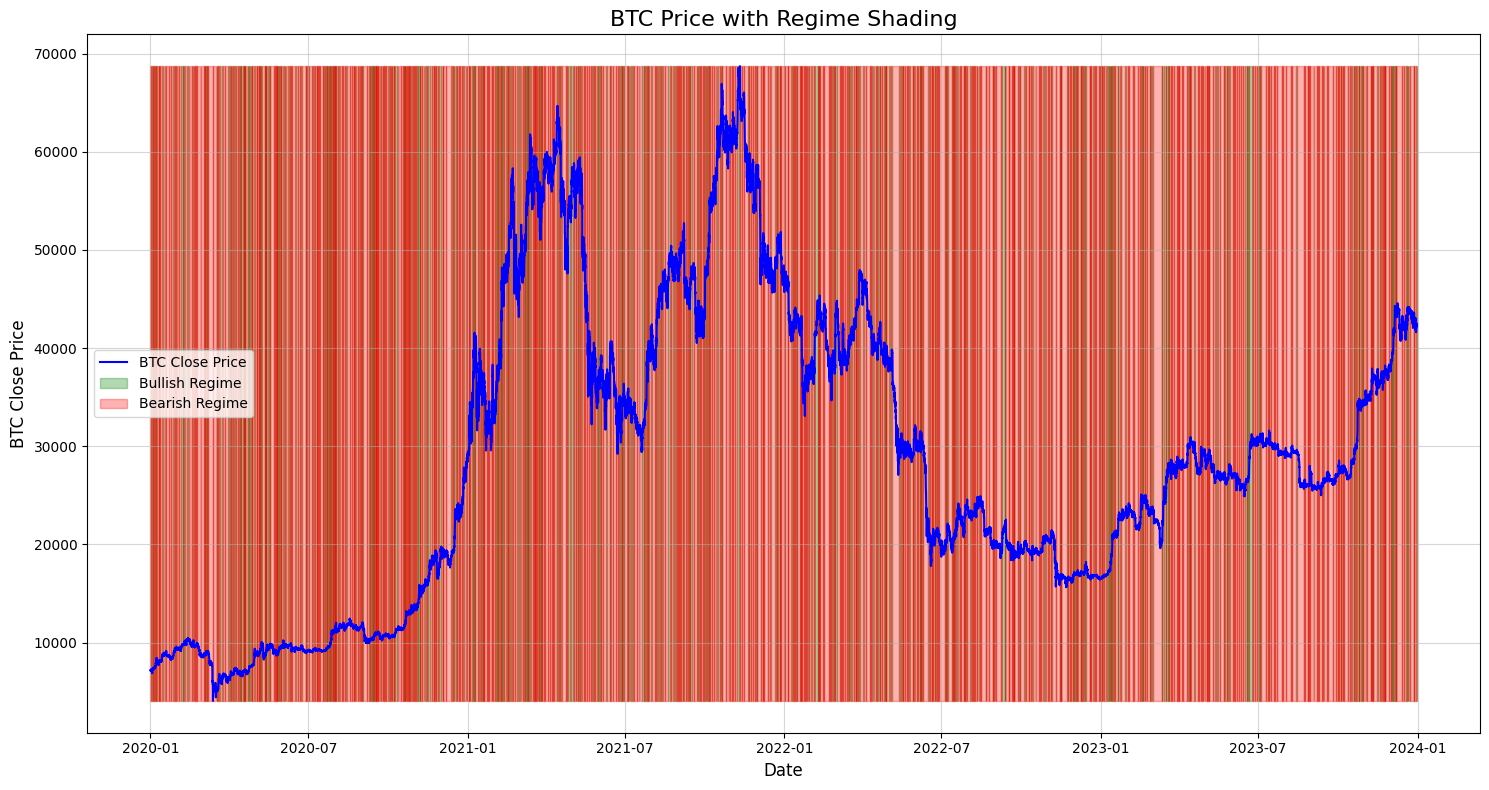

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your processed data with BTC regimes
# Replace with your actual file or DataFrame
data = pd.read_csv("file.csv", parse_dates=["datetime"])

# Extract the required columns
datetime = data["datetime"]
btc_close = data["btc_close"]
btc_regime = data["btc_regime"]

# Create the plot
plt.figure(figsize=(15, 8))
plt.plot(datetime, btc_close, label="BTC Close Price", color="blue", linewidth=1.5)

# Add shaded regions based on the regime
plt.fill_between(
    datetime,
    btc_close.min() - 10,
    btc_close.max() + 10,
    where=(btc_regime == "bullish"),
    color="green",
    alpha=0.3,
    label="Bullish Regime",
)
plt.fill_between(
    datetime,
    btc_close.min() - 10,
    btc_close.max() + 10,
    where=(btc_regime == "bearish"),
    color="red",
    alpha=0.3,
    label="Bearish Regime",
)

# Add labels, legend, and grid
plt.title("BTC Price with Regime Shading", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("BTC Close Price", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [34]:
# # print(type(last_value))
# # last_value
# backtester_output = last_value
# cleaned_output = backtester_output.lstrip("data: ").strip("\'")
# cleaned_output

In [35]:
# json_output = json.loads(cleaned_output)

# sharpe_ratio = json_output["result"]["static_statistics"]["Sharpe Ratio"]

# print("Sharpe Ratio:", sharpe_ratio)

In [36]:
# df_sub = pd.read_csv("strategy_results.csv")
# res = BacktestResults(df_sub, cash = 1000.0, commission = 0.0015)
# res.static_metrics()
# res.compounded_metrics()
# print(res.sharpe)

In [37]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Function to calculate Sharpe Ratio for different stop loss values
# def analyze_stoploss_sharpe(cash, commission, maxhold, cooldown):
#     """
#     Analyze Sharpe Ratio for varying stop loss and trailing stop loss percentages.

#     Parameters:
#     - df: DataFrame containing backtesting data.
#     - cash: Initial cash for the portfolio.
#     - commission: Commission for each trade.
#     - stoploss_values: List of stop loss percentages to test.
#     - atr_stop_values: List of trailing stop loss percentages to test.

#     Returns:
#     - sharpe_matrix: 2D matrix of Sharpe Ratios for stoploss and trailing stoploss values.
#     """
#     sharpe_matrix = np.zeros((len(maxhold), len(cooldown)))

#     for i, mx in enumerate(maxhold):
#         for j, cd in enumerate(cooldown):
#             print(i, j)
#             # Apply strategy
#             strategized_data = strat(data, maxhold=mx, cooldown=cd)

#             csv_file_path = "strategy_results.csv"

#             # Save processed data to CSV file
#             strategized_data.to_csv(csv_file_path, index=False)
            
#             # Perform backtest on processed data
#             backtest_result = perform_backtest(csv_file_path)

#             # Get the last value of backtest result
#             last_value = None
#             for value in backtest_result:
#                 # print(value)  # Uncomment to see the full backtest result (backtest_result is a generator object)
#                 last_value = value
#             # print(last_value)

#             json_output = json.loads(last_value.lstrip("data: ").strip("\'"))
#             sharpe_ratio = json_output["result"]["static_statistics"]["Sharpe Ratio"]
            
#             # Store the Sharpe Ratio
#             sharpe_matrix[i, j] = sharpe_ratio

#     return sharpe_matrix


# # Set the ranges of stop loss and trailing stop loss percentages
# maxhold = np.array([7, 14, 21, 28, 35])  # Example: 1% to 10%
# cooldown = np.array([12, 24, 48, 72, 96])  # Example: 1% to 10%

# # Perform the analysis
# sharpe_matrix = analyze_stoploss_sharpe(
#     cash=1000.0,
#     commission=0.0015,
#     maxhold=maxhold,
#     cooldown=cooldown
# )

In [38]:
# # Create a heatmap for Sharpe Ratios
# plt.figure(figsize=(12, 8))
# sns.heatmap(
#     sharpe_matrix,
#     xticklabels=np.round(maxhold, 1),  # Convert to percentages for display
#     yticklabels=np.round(cooldown, 1),  # Convert to percentages for display
#     annot=True,
#     fmt=".2f",
#     cmap="coolwarm",
#     cbar_kws={'label': 'Sharpe Ratio'}  # Add colorbar label
# )
# plt.title("Sharpe Ratio Heatmap", fontsize=16)
# plt.xlabel("Max Holding Period (days)", fontsize=12)
# plt.ylabel("Cooldown Period (hours)", fontsize=12)
# plt.xticks(fontsize=10)
# plt.yticks(fontsize=10)
# plt.tight_layout()
# plt.show()